In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 14.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('smiles_tg.csv')
df = df.drop_duplicates(subset='SMILES').reset_index(drop=True)
print(f"Unique SMILES count: {df.shape[0]}")


Unique SMILES count: 964


In [5]:
def get_basic_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        'MW': Descriptors.MolWt(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'Rotatable_Bonds': Descriptors.NumRotatableBonds(mol)
    }

def get_morgan_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return list(fp)


In [6]:
desc_list = [get_basic_descriptors(smi) for smi in df['SMILES']]
desc_list = [d for d in desc_list if d is not None]
df_desc = pd.DataFrame(desc_list)

fingerprints = [get_morgan_fingerprint(smi) for smi in df['SMILES']]
fingerprints = [fp for fp in fingerprints if fp is not None]
df_fp = pd.DataFrame(fingerprints)

# Combine
df_features = pd.concat([df_desc, df_fp], axis=1)
df_features['tg'] = df['tg'][:len(df_features)]


[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerator
[02:11:44] DEPRECATION WARNING: please use MorganGenerat

In [7]:
X = df_features.drop(columns=['tg'])
y = df_features['tg']

# Convert all column names to strings
X.columns = X.columns.astype(str)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.1, random_state=42)


Ridge R2: -5.929, RMSE: 221556.431


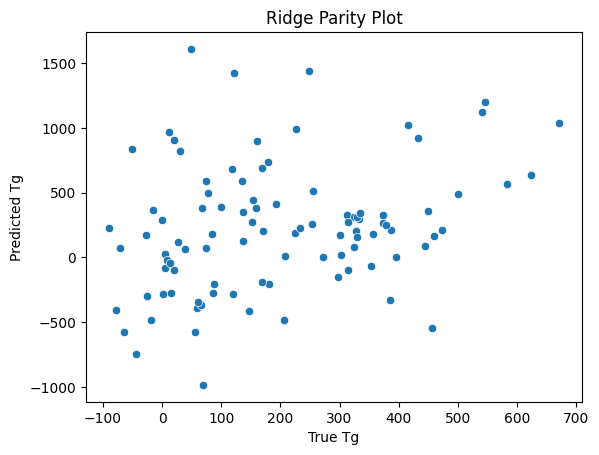

Random Forest R2: 0.624, RMSE: 12013.323


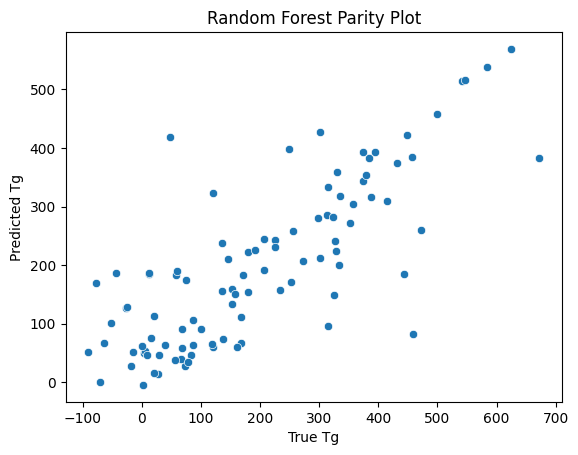

SVR R2: 0.000, RMSE: 31961.647


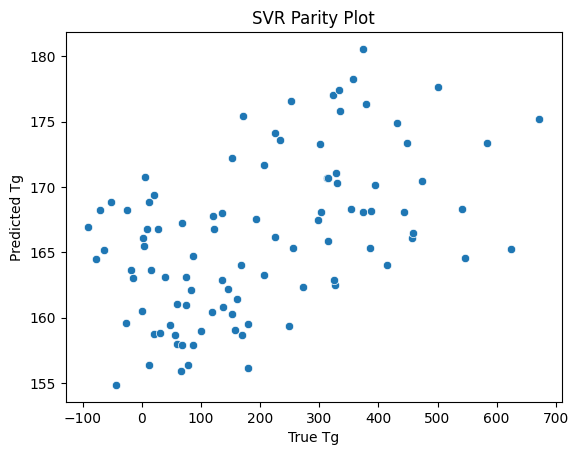

MLP R2: 0.386, RMSE: 19644.029


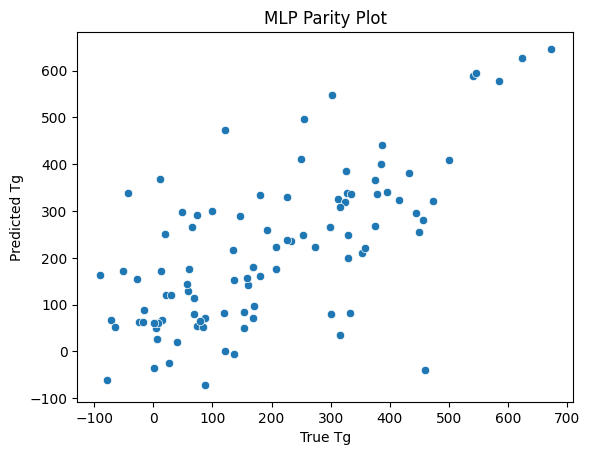

In [8]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    print(f"{name} R2: {r2_score(y_test, y_pred):.3f}, RMSE: {mean_squared_error(y_test, y_pred):.3f}")
    sns.scatterplot(x=y_test, y=y_pred)
    plt.title(f'{name} Parity Plot')
    plt.xlabel('True Tg')
    plt.ylabel('Predicted Tg')
    plt.show()

models = {
    'Ridge': Ridge(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate(model, name)


Epoch 0, Loss: 60545.0977
Epoch 50, Loss: 42249.8398
Epoch 100, Loss: 5653.8374
Epoch 150, Loss: 2895.0442
Epoch 200, Loss: 2081.9226
Epoch 250, Loss: 1620.6307
PyTorch ANN R2: 0.612, RMSE: 12419.823


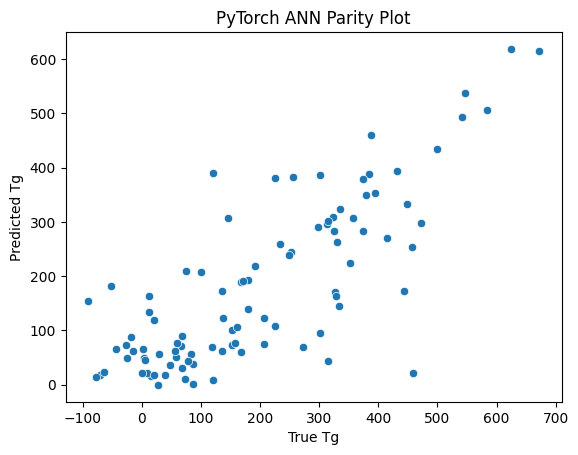

In [9]:
class ANN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32).to(device)

model = ANN(X_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training Loop
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy().flatten()
    print(f"PyTorch ANN R2: {r2_score(y_test, preds):.3f}, RMSE: {mean_squared_error(y_test, preds):.3f}")
    sns.scatterplot(x=y_test, y=preds)
    plt.title("PyTorch ANN Parity Plot")
    plt.xlabel("True Tg")
    plt.ylabel("Predicted Tg")
    plt.show()
